In [1]:
from __future__ import print_function 
import numpy as np
import torch
import torch.autograd as ag
from matplotlib import pyplot
import torch.nn as nn
import torch.nn.functional as F
from math import exp
import matplotlib as pyplot 
import torchvision
import torchvision.transforms as transforms

#########################Load and reshape image###############################
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [2]:
class generator(nn.Module):

    def __init__(self):
        super(generator, self).__init__()
        #ConvTranspose2d(input_channels,output_channels,kernel_size,stride,padding_value)
        #BatchNorm2d: Applies Batch Normalization over a 4d input that is seen as a mini-batch of 3d inputs
        
        self.deconv1 = nn.ConvTranspose2d(100, 128, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(32)
        self.deconv4 = nn.ConvTranspose2d(32, 3, 4, 2, 1)

    #Weights initialized from a zero-centered normal distribution with standard deviation 0.02
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.tanh(self.deconv4(x))

        return x
    
    
class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1)
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.sigmoid(self.conv4(x))

        return x

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()
        


In [3]:
G = generator()
D = discriminator()
if torch.cuda.is_available():
    G.cuda()
    D.cuda()
    print ('USE GPU')


G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
 
y_real = torch.ones(100)
y_fake = torch.zeros(100)
y_real = ag.Variable(y_real.cuda())
y_fake = ag.Variable(y_fake.cuda())    

USE GPU


In [4]:
criterion = nn.BCELoss()
T = 30               # Number of epochs
gamma = .00005         # Learning rate
rho = .5              # Momentum
      
G_optimizer = torch.optim.Adam(G.parameters(), lr=gamma, betas=(rho, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=gamma, betas=(rho, 0.999))

D_losses = []
G_losses = []
for epoch in range(T): 
    
    for i, data in enumerate(trainloader,0):
        inputs, labels = data
        

        inputs = ag.Variable(inputs.cuda(),requires_grad=True)
        labels = ag.Variable(labels.cuda(),requires_grad=True)
        D.zero_grad()
        
        D_result = D(inputs).squeeze()              #Real data and losses
        #print(D_result.shape)
        D_real_loss = criterion(D_result, y_real)    #labels is a matrix with ones
            
        z_ = torch.randn((100, 100)).view(-1, 100, 1, 1)    
        z_ = ag.Variable(z_.cuda())
        G_result = G(z_)                            #Generated images by G from noises
        
        D_result = D(G_result).squeeze()
        D_fake_loss = criterion(D_result, y_fake)
        D_fake_score = D_result.data.mean()

        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()
            
        D_losses.append(D_train_loss.data[0])
            
        # train generator G
        G.zero_grad()

        z_ = torch.randn((100, 100)).view(-1, 100, 1, 1)
        z_ = ag.Variable(z_.cuda())

        G_result = G(z_)            
        D_result = D(G_result).squeeze()
        G_train_loss = criterion(D_result, y_real)
        G_train_loss.backward()
        G_optimizer.step()
        
        G_losses.append(G_train_loss.data[0])
    
        if i % 250 == 0:
            print('[%d/%d], loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), T, D_train_loss.data[0],
                                                              G_train_loss.data[0]))

[1/30], loss_d: 1.372, loss_g: 0.879
[1/30], loss_d: 0.078, loss_g: 3.595
[2/30], loss_d: 0.067, loss_g: 3.861
[2/30], loss_d: 0.042, loss_g: 4.560
[3/30], loss_d: 0.133, loss_g: 3.699
[3/30], loss_d: 0.210, loss_g: 3.142
[4/30], loss_d: 0.268, loss_g: 2.765
[4/30], loss_d: 0.388, loss_g: 2.281
[5/30], loss_d: 0.406, loss_g: 2.118
[5/30], loss_d: 0.524, loss_g: 2.414
[6/30], loss_d: 0.582, loss_g: 1.902
[6/30], loss_d: 0.716, loss_g: 2.120
[7/30], loss_d: 0.616, loss_g: 1.731
[7/30], loss_d: 0.616, loss_g: 1.912
[8/30], loss_d: 0.696, loss_g: 1.514
[8/30], loss_d: 0.537, loss_g: 1.999
[9/30], loss_d: 0.343, loss_g: 2.113
[9/30], loss_d: 0.399, loss_g: 1.997
[10/30], loss_d: 0.368, loss_g: 2.863
[10/30], loss_d: 0.271, loss_g: 3.015
[11/30], loss_d: 0.207, loss_g: 2.569
[11/30], loss_d: 0.323, loss_g: 2.548
[12/30], loss_d: 0.333, loss_g: 3.463
[12/30], loss_d: 0.226, loss_g: 2.071
[13/30], loss_d: 0.204, loss_g: 2.390
[13/30], loss_d: 0.359, loss_g: 2.025
[14/30], loss_d: 0.291, loss_g

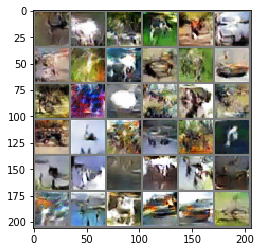

In [13]:
import matplotlib.pyplot as plt
z_ = torch.randn((36,100)).view(-1, 100, 1, 1)

z_ = ag.Variable(z_.cuda(), volatile=True)
test_images = G(z_).cpu()
test_images = test_images.data.numpy()
test_images = test_images.squeeze()
test_images = torch.from_numpy(test_images).float()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
imshow(torchvision.utils.make_grid(test_images,6))

  cat  ship  ship plane  frog  frog   car  frog


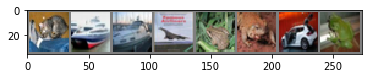

In [6]:
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

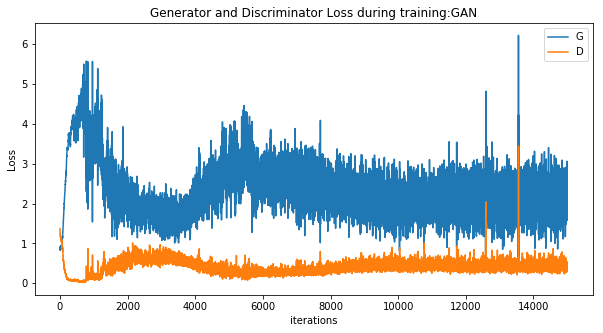

In [12]:
# Plot of Discriminator and Generator's losses  
plt.figure(figsize=(10, 5))
plt.title('Generator and Discriminator Loss during training:GAN')
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()  

In [14]:
torch.save(G.state_dict(), 'DC1_CIFAR_netG.pt')
torch.save(D.state_dict(), 'DC1_CIFAR_netD.pt')

In [18]:
tempD = []
Dloss = []

#test all real data on discriminator of GMAN
for epoch in range(10):
    for i, data in enumerate(testloader, 0):
        realImg = ag.Variable(data[0].cuda())
        batchSize = realImg.size(0)
        realLabel = torch.ones(100)
        realLabel = realLabel.cuda()
        output = D(realImg).view(-1)
        D_x = output.mean().data
        tempD.append(D_x)
    av_d = sum(tempD)/len(tempD)
    Dloss.append(av_d)
D2_test = sum(Dloss)/len(Dloss)

print(D2_test)


 0.7785
[torch.cuda.FloatTensor of size 1 (GPU 0)]

